# PyTorch Classifier Benchmark

```{contents}
```

## Load data

In [1]:
import pandas as pd

input_path = '../Data/Intermediate_Files/'
output_path = '../Data/Processed_Data/'

# Load pacmap output data
df = pd.read_csv(output_path+'pacmap_output/pacmap_5d_output_acute_leukemia.csv', index_col=0)

## Preprocess data

### Exclude categories with <10 samples

In [3]:
# exclude the samples with mixed phenotypes and Down syndrome and t(9;22)(q34.1;q11.2)/BCR::ABL1
df = df[~df['ELN AML 2022 Diagnosis'].isin(['Mixed phenotype acute leukemia T/myeloid',
                                       'Myeloid leukaemia associated with Down syndrome',
                                       'AML with t(9;22)(q34.1;q11.2)/BCR::ABL1'])]

df['ELN AML 2022 Diagnosis'].value_counts()

ELN AML 2022 Diagnosis
AML with t(9;11)(p22;q23.3)/KMT2A-rearrangement                           360
AML with inv(16)(p13.1q22) or t(16;16)(p13.1;q22)/CBFB::MYH11             201
AML with t(8;21)(q22;q22.1)/RUNX1::RUNX1T1                                198
AML with other rare recurring translocations                              172
AML with mutated NPM1                                                     172
MDS-related or secondary myeloid neoplasms                                148
Otherwise-Normal Control                                                  121
AML with in-frame bZIP mutated CEBPA                                       69
APL with t(15;17)(q24.1;q21.2)/PML::RARA                                   31
AML with t(6;9)(p23;q34.1)/DEK::NUP214                                     27
AML with inv(3)(q21.3q26.2) or t(3;3)(q21.3;q26.2)/MECOM-rearrangement     10
Name: count, dtype: int64

### Exclude samples with missing labels

In [4]:
# drop the samples with missing labels for the ELN AML 2022 Diagnosis
df = df[~df['ELN AML 2022 Diagnosis'].isna()]

### Define X and y

In [7]:

# Define X and y
X = df[['PaCMAP 1', 'PaCMAP 2', 'PaCMAP 3', 'PaCMAP 4', 'PaCMAP 5']].to_numpy() # shape (n_samples=1399, n_features=5)
y = df['ELN AML 2022 Diagnosis'].to_numpy() # shape (n_samples=1399,) with 11 string classes

## Deep Learning

In [8]:
# One hot encode the labels
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
label_encoder = LabelEncoder()
integer_encoded = label_encoder.fit_transform(y)
onehot_encoder = OneHotEncoder(sparse_output=False)
integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
y = onehot_encoder.fit_transform(integer_encoded)

In [9]:

# Split the data into train/test sets based on the `Train Test` column
X_train = X[df['Train Test']=='Discovery (train) Samples']
y_train = y[df['Train Test']=='Discovery (train) Samples']
X_test = X[df['Train Test']=='Validation (test) Samples']
y_test = y[df['Train Test']=='Validation (test) Samples']

## Define model architecture

 Input -> Hidden Layer 1 -> Activation -> Hidden Layer 2 -> Activation -> Output Layer

In [13]:
import copy

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import tqdm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder


# convert pandas DataFrame (X) and numpy array (y) into PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

In [19]:

class Multiclass(nn.Module):
    def __init__(self):
        super().__init__()
        self.hidden1 = nn.Linear(5, 10)
        self.hidden2 = nn.Linear(10, 20)
        self.act = nn.ReLU()
        self.output = nn.Linear(20, 11)

    def forward(self, x):
        x = self.act(self.hidden1(x))
        x = self.act(self.hidden2(x))
        x = self.output(x)
        return x

# loss metric and optimizer
model = Multiclass()
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# prepare model and training parameters
n_epochs = 100
batch_size = 5
batches_per_epoch = len(X_train) // batch_size

best_acc = - np.inf   # init to negative infinity
best_weights = None
train_loss_hist = []
train_acc_hist = []
test_loss_hist = []
test_acc_hist = []

# training loop
for epoch in range(n_epochs):
    epoch_loss = []
    epoch_acc = []
    # set model in training mode and run through each batch
    model.train()
    with tqdm.trange(batches_per_epoch, unit="batch", mininterval=0) as bar:
        bar.set_description(f"Epoch {epoch}")
        for i in bar:
            # take a batch
            start = i * batch_size
            X_batch = X_train[start:start+batch_size]
            y_batch = y_train[start:start+batch_size]
            # forward pass
            y_pred = model(X_batch)
            loss = loss_fn(y_pred, y_batch)
            # backward pass
            optimizer.zero_grad()
            loss.backward()
            # update weights
            optimizer.step()
            # compute and store metrics
            acc = (torch.argmax(y_pred, 1) == torch.argmax(y_batch, 1)).float().mean()
            epoch_loss.append(float(loss))
            epoch_acc.append(float(acc))
            bar.set_postfix(
                loss=float(loss),
                acc=float(acc)
            )
    # set model in evaluation mode and run through the test set
    model.eval()
    y_pred = model(X_test)
    ce = loss_fn(y_pred, y_test)
    acc = (torch.argmax(y_pred, 1) == torch.argmax(y_test, 1)).float().mean()
    ce = float(ce)
    acc = float(acc)
    train_loss_hist.append(np.mean(epoch_loss))
    train_acc_hist.append(np.mean(epoch_acc))
    test_loss_hist.append(ce)
    test_acc_hist.append(acc)
    if acc > best_acc:
        best_acc = acc
        best_weights = copy.deepcopy(model.state_dict())
    print(f"Epoch {epoch} validation: Cross-entropy={ce:.2f}, Accuracy={acc*100:.1f}%")

# Restore best model
model.load_state_dict(best_weights)

Epoch 0: 100%|██████████| 279/279 [00:00<00:00, 722.65batch/s, acc=0, loss=2.12]   


Epoch 0 validation: Cross-entropy=0.70, Accuracy=82.7%


Epoch 1: 100%|██████████| 279/279 [00:00<00:00, 642.09batch/s, acc=0.2, loss=1.72] 


Epoch 1 validation: Cross-entropy=0.54, Accuracy=82.7%


Epoch 2: 100%|██████████| 279/279 [00:00<00:00, 616.25batch/s, acc=0.4, loss=1.37] 


Epoch 2 validation: Cross-entropy=0.47, Accuracy=82.7%


Epoch 3: 100%|██████████| 279/279 [00:00<00:00, 575.30batch/s, acc=0.6, loss=1.18] 


Epoch 3 validation: Cross-entropy=0.41, Accuracy=90.0%


Epoch 4: 100%|██████████| 279/279 [00:00<00:00, 607.75batch/s, acc=0.6, loss=1.1]  


Epoch 4 validation: Cross-entropy=0.39, Accuracy=91.8%


Epoch 5: 100%|██████████| 279/279 [00:00<00:00, 602.71batch/s, acc=0.6, loss=1.06] 


Epoch 5 validation: Cross-entropy=0.38, Accuracy=91.8%


Epoch 6: 100%|██████████| 279/279 [00:00<00:00, 610.50batch/s, acc=0.8, loss=1]    


Epoch 6 validation: Cross-entropy=0.37, Accuracy=91.8%


Epoch 7: 100%|██████████| 279/279 [00:00<00:00, 599.81batch/s, acc=0.8, loss=0.966]


Epoch 7 validation: Cross-entropy=0.37, Accuracy=92.7%


Epoch 8: 100%|██████████| 279/279 [00:00<00:00, 583.66batch/s, acc=0.8, loss=0.935]


Epoch 8 validation: Cross-entropy=0.36, Accuracy=92.7%


Epoch 9: 100%|██████████| 279/279 [00:00<00:00, 613.63batch/s, acc=0.8, loss=0.925]


Epoch 9 validation: Cross-entropy=0.36, Accuracy=92.7%


Epoch 10: 100%|██████████| 279/279 [00:00<00:00, 588.40batch/s, acc=0.8, loss=0.909]


Epoch 10 validation: Cross-entropy=0.36, Accuracy=92.7%


Epoch 11: 100%|██████████| 279/279 [00:00<00:00, 590.87batch/s, acc=0.8, loss=0.9]  


Epoch 11 validation: Cross-entropy=0.36, Accuracy=92.7%


Epoch 12: 100%|██████████| 279/279 [00:00<00:00, 609.39batch/s, acc=0.8, loss=0.881]


Epoch 12 validation: Cross-entropy=0.36, Accuracy=92.7%


Epoch 13: 100%|██████████| 279/279 [00:00<00:00, 574.53batch/s, acc=0.8, loss=0.872]


Epoch 13 validation: Cross-entropy=0.36, Accuracy=92.7%


Epoch 14: 100%|██████████| 279/279 [00:00<00:00, 601.30batch/s, acc=0.8, loss=0.87] 


Epoch 14 validation: Cross-entropy=0.36, Accuracy=92.7%


Epoch 15: 100%|██████████| 279/279 [00:00<00:00, 584.97batch/s, acc=0.8, loss=0.864]


Epoch 15 validation: Cross-entropy=0.37, Accuracy=92.7%


Epoch 16: 100%|██████████| 279/279 [00:00<00:00, 594.70batch/s, acc=0.8, loss=0.864]


Epoch 16 validation: Cross-entropy=0.37, Accuracy=92.7%


Epoch 17: 100%|██████████| 279/279 [00:00<00:00, 600.70batch/s, acc=0.8, loss=0.858]


Epoch 17 validation: Cross-entropy=0.37, Accuracy=92.7%


Epoch 18: 100%|██████████| 279/279 [00:00<00:00, 586.30batch/s, acc=0.8, loss=0.856]


Epoch 18 validation: Cross-entropy=0.38, Accuracy=92.7%


Epoch 19: 100%|██████████| 279/279 [00:00<00:00, 613.07batch/s, acc=0.8, loss=0.856]


Epoch 19 validation: Cross-entropy=0.37, Accuracy=92.7%


Epoch 20: 100%|██████████| 279/279 [00:00<00:00, 595.97batch/s, acc=0.8, loss=0.847]


Epoch 20 validation: Cross-entropy=0.39, Accuracy=92.7%


Epoch 21: 100%|██████████| 279/279 [00:00<00:00, 601.25batch/s, acc=0.8, loss=0.843]


Epoch 21 validation: Cross-entropy=0.38, Accuracy=93.6%


Epoch 22: 100%|██████████| 279/279 [00:00<00:00, 601.36batch/s, acc=0.8, loss=0.836]


Epoch 22 validation: Cross-entropy=0.39, Accuracy=92.7%


Epoch 23: 100%|██████████| 279/279 [00:00<00:00, 650.92batch/s, acc=0.8, loss=0.837]


Epoch 23 validation: Cross-entropy=0.39, Accuracy=93.6%


Epoch 24: 100%|██████████| 279/279 [00:00<00:00, 692.51batch/s, acc=0.8, loss=0.829]


Epoch 24 validation: Cross-entropy=0.39, Accuracy=92.7%


Epoch 25: 100%|██████████| 279/279 [00:00<00:00, 690.58batch/s, acc=0.8, loss=0.823]


Epoch 25 validation: Cross-entropy=0.39, Accuracy=93.6%


Epoch 26: 100%|██████████| 279/279 [00:00<00:00, 657.69batch/s, acc=0.8, loss=0.819]


Epoch 26 validation: Cross-entropy=0.40, Accuracy=93.6%


Epoch 27: 100%|██████████| 279/279 [00:00<00:00, 721.36batch/s, acc=0.8, loss=0.823]


Epoch 27 validation: Cross-entropy=0.40, Accuracy=93.6%


Epoch 28: 100%|██████████| 279/279 [00:00<00:00, 701.99batch/s, acc=0.8, loss=0.818]


Epoch 28 validation: Cross-entropy=0.41, Accuracy=93.6%


Epoch 29: 100%|██████████| 279/279 [00:00<00:00, 672.23batch/s, acc=0.8, loss=0.818]


Epoch 29 validation: Cross-entropy=0.41, Accuracy=93.6%


Epoch 30: 100%|██████████| 279/279 [00:00<00:00, 705.82batch/s, acc=0.8, loss=0.815]


Epoch 30 validation: Cross-entropy=0.42, Accuracy=93.6%


Epoch 31: 100%|██████████| 279/279 [00:00<00:00, 687.29batch/s, acc=0.8, loss=0.807]


Epoch 31 validation: Cross-entropy=0.42, Accuracy=93.6%


Epoch 32: 100%|██████████| 279/279 [00:00<00:00, 713.31batch/s, acc=0.8, loss=0.801]


Epoch 32 validation: Cross-entropy=0.42, Accuracy=93.6%


Epoch 33: 100%|██████████| 279/279 [00:00<00:00, 683.52batch/s, acc=0.8, loss=0.799]


Epoch 33 validation: Cross-entropy=0.42, Accuracy=93.6%


Epoch 34: 100%|██████████| 279/279 [00:00<00:00, 699.32batch/s, acc=0.8, loss=0.8]  


Epoch 34 validation: Cross-entropy=0.42, Accuracy=93.6%


Epoch 35: 100%|██████████| 279/279 [00:00<00:00, 703.52batch/s, acc=0.8, loss=0.794]


Epoch 35 validation: Cross-entropy=0.43, Accuracy=93.6%


Epoch 36: 100%|██████████| 279/279 [00:00<00:00, 695.17batch/s, acc=0.8, loss=0.794]


Epoch 36 validation: Cross-entropy=0.43, Accuracy=93.6%


Epoch 37: 100%|██████████| 279/279 [00:00<00:00, 695.79batch/s, acc=0.8, loss=0.776]


Epoch 37 validation: Cross-entropy=0.43, Accuracy=93.6%


Epoch 38: 100%|██████████| 279/279 [00:00<00:00, 706.16batch/s, acc=0.8, loss=0.774]


Epoch 38 validation: Cross-entropy=0.43, Accuracy=93.6%


Epoch 39: 100%|██████████| 279/279 [00:00<00:00, 638.40batch/s, acc=0.8, loss=0.783]


Epoch 39 validation: Cross-entropy=0.44, Accuracy=93.6%


Epoch 40: 100%|██████████| 279/279 [00:00<00:00, 665.53batch/s, acc=0.8, loss=0.777]


Epoch 40 validation: Cross-entropy=0.44, Accuracy=93.6%


Epoch 41: 100%|██████████| 279/279 [00:00<00:00, 688.16batch/s, acc=0.8, loss=0.78] 


Epoch 41 validation: Cross-entropy=0.44, Accuracy=93.6%


Epoch 42: 100%|██████████| 279/279 [00:00<00:00, 680.03batch/s, acc=0.8, loss=0.778]


Epoch 42 validation: Cross-entropy=0.45, Accuracy=93.6%


Epoch 43: 100%|██████████| 279/279 [00:00<00:00, 731.89batch/s, acc=0.6, loss=0.755]


Epoch 43 validation: Cross-entropy=0.45, Accuracy=93.6%


Epoch 44: 100%|██████████| 279/279 [00:00<00:00, 719.78batch/s, acc=1, loss=0.739]  


Epoch 44 validation: Cross-entropy=0.46, Accuracy=93.6%


Epoch 45: 100%|██████████| 279/279 [00:00<00:00, 641.97batch/s, acc=0.6, loss=0.745]


Epoch 45 validation: Cross-entropy=0.45, Accuracy=93.6%


Epoch 46: 100%|██████████| 279/279 [00:00<00:00, 703.59batch/s, acc=0.8, loss=0.732]


Epoch 46 validation: Cross-entropy=0.46, Accuracy=93.6%


Epoch 47: 100%|██████████| 279/279 [00:00<00:00, 712.66batch/s, acc=0.8, loss=0.717]


Epoch 47 validation: Cross-entropy=0.46, Accuracy=93.6%


Epoch 48: 100%|██████████| 279/279 [00:00<00:00, 700.98batch/s, acc=0.8, loss=0.701]


Epoch 48 validation: Cross-entropy=0.46, Accuracy=93.6%


Epoch 49: 100%|██████████| 279/279 [00:00<00:00, 694.59batch/s, acc=0.8, loss=0.709]


Epoch 49 validation: Cross-entropy=0.46, Accuracy=93.6%


Epoch 50: 100%|██████████| 279/279 [00:00<00:00, 711.70batch/s, acc=1, loss=0.693]  


Epoch 50 validation: Cross-entropy=0.47, Accuracy=93.6%


Epoch 51: 100%|██████████| 279/279 [00:00<00:00, 720.72batch/s, acc=0.8, loss=0.697]


Epoch 51 validation: Cross-entropy=0.47, Accuracy=93.6%


Epoch 52: 100%|██████████| 279/279 [00:00<00:00, 703.34batch/s, acc=0.8, loss=0.683]


Epoch 52 validation: Cross-entropy=0.47, Accuracy=93.6%


Epoch 53: 100%|██████████| 279/279 [00:00<00:00, 619.03batch/s, acc=0.8, loss=0.693]


Epoch 53 validation: Cross-entropy=0.48, Accuracy=93.6%


Epoch 54: 100%|██████████| 279/279 [00:00<00:00, 612.75batch/s, acc=0.8, loss=0.676]


Epoch 54 validation: Cross-entropy=0.48, Accuracy=93.6%


Epoch 55: 100%|██████████| 279/279 [00:00<00:00, 649.02batch/s, acc=0.8, loss=0.667]


Epoch 55 validation: Cross-entropy=0.48, Accuracy=93.6%


Epoch 56: 100%|██████████| 279/279 [00:00<00:00, 561.63batch/s, acc=0.8, loss=0.647]


Epoch 56 validation: Cross-entropy=0.48, Accuracy=93.6%


Epoch 57: 100%|██████████| 279/279 [00:00<00:00, 528.48batch/s, acc=0.8, loss=0.651]


Epoch 57 validation: Cross-entropy=0.50, Accuracy=93.6%


Epoch 58: 100%|██████████| 279/279 [00:00<00:00, 566.60batch/s, acc=0.8, loss=0.643]


Epoch 58 validation: Cross-entropy=0.49, Accuracy=93.6%


Epoch 59: 100%|██████████| 279/279 [00:00<00:00, 581.13batch/s, acc=0.8, loss=0.626]


Epoch 59 validation: Cross-entropy=0.49, Accuracy=93.6%


Epoch 60: 100%|██████████| 279/279 [00:00<00:00, 579.20batch/s, acc=0.8, loss=0.616]


Epoch 60 validation: Cross-entropy=0.51, Accuracy=93.6%


Epoch 61: 100%|██████████| 279/279 [00:00<00:00, 560.62batch/s, acc=0.8, loss=0.62] 


Epoch 61 validation: Cross-entropy=0.50, Accuracy=93.6%


Epoch 62: 100%|██████████| 279/279 [00:00<00:00, 592.03batch/s, acc=0.8, loss=0.607]


Epoch 62 validation: Cross-entropy=0.51, Accuracy=93.6%


Epoch 63: 100%|██████████| 279/279 [00:00<00:00, 580.49batch/s, acc=0.8, loss=0.621]


Epoch 63 validation: Cross-entropy=0.50, Accuracy=93.6%


Epoch 64: 100%|██████████| 279/279 [00:00<00:00, 576.04batch/s, acc=0.8, loss=0.625]


Epoch 64 validation: Cross-entropy=0.51, Accuracy=93.6%


Epoch 65: 100%|██████████| 279/279 [00:00<00:00, 603.59batch/s, acc=0.8, loss=0.603]


Epoch 65 validation: Cross-entropy=0.52, Accuracy=93.6%


Epoch 66: 100%|██████████| 279/279 [00:00<00:00, 595.88batch/s, acc=0.8, loss=0.615]


Epoch 66 validation: Cross-entropy=0.52, Accuracy=93.6%


Epoch 67: 100%|██████████| 279/279 [00:00<00:00, 568.74batch/s, acc=0.8, loss=0.601]


Epoch 67 validation: Cross-entropy=0.53, Accuracy=93.6%


Epoch 68: 100%|██████████| 279/279 [00:00<00:00, 597.33batch/s, acc=0.8, loss=0.629]


Epoch 68 validation: Cross-entropy=0.50, Accuracy=93.6%


Epoch 69: 100%|██████████| 279/279 [00:00<00:00, 571.57batch/s, acc=0.8, loss=0.607]


Epoch 69 validation: Cross-entropy=0.52, Accuracy=93.6%


Epoch 70: 100%|██████████| 279/279 [00:00<00:00, 555.07batch/s, acc=0.8, loss=0.59] 


Epoch 70 validation: Cross-entropy=0.53, Accuracy=93.6%


Epoch 71: 100%|██████████| 279/279 [00:00<00:00, 580.23batch/s, acc=0.8, loss=0.594]


Epoch 71 validation: Cross-entropy=0.52, Accuracy=93.6%


Epoch 72: 100%|██████████| 279/279 [00:00<00:00, 586.70batch/s, acc=0.8, loss=0.592]


Epoch 72 validation: Cross-entropy=0.53, Accuracy=93.6%


Epoch 73: 100%|██████████| 279/279 [00:00<00:00, 604.39batch/s, acc=0.8, loss=0.591]


Epoch 73 validation: Cross-entropy=0.53, Accuracy=93.6%


Epoch 74: 100%|██████████| 279/279 [00:00<00:00, 575.04batch/s, acc=0.8, loss=0.589]


Epoch 74 validation: Cross-entropy=0.53, Accuracy=93.6%


Epoch 75: 100%|██████████| 279/279 [00:00<00:00, 563.94batch/s, acc=0.8, loss=0.633]


Epoch 75 validation: Cross-entropy=0.51, Accuracy=93.6%


Epoch 76: 100%|██████████| 279/279 [00:00<00:00, 574.09batch/s, acc=0.8, loss=0.609]


Epoch 76 validation: Cross-entropy=0.54, Accuracy=93.6%


Epoch 77: 100%|██████████| 279/279 [00:00<00:00, 574.41batch/s, acc=0.8, loss=0.607]


Epoch 77 validation: Cross-entropy=0.54, Accuracy=93.6%


Epoch 78: 100%|██████████| 279/279 [00:00<00:00, 586.53batch/s, acc=0.8, loss=0.6]  


Epoch 78 validation: Cross-entropy=0.54, Accuracy=93.6%


Epoch 79: 100%|██████████| 279/279 [00:00<00:00, 561.01batch/s, acc=0.8, loss=0.613]


Epoch 79 validation: Cross-entropy=0.54, Accuracy=93.6%


Epoch 80: 100%|██████████| 279/279 [00:00<00:00, 575.31batch/s, acc=0.8, loss=0.59] 


Epoch 80 validation: Cross-entropy=0.55, Accuracy=93.6%


Epoch 81: 100%|██████████| 279/279 [00:00<00:00, 590.12batch/s, acc=0.8, loss=0.614]


Epoch 81 validation: Cross-entropy=0.56, Accuracy=93.6%


Epoch 82: 100%|██████████| 279/279 [00:00<00:00, 604.28batch/s, acc=0.8, loss=0.6]  


Epoch 82 validation: Cross-entropy=0.55, Accuracy=93.6%


Epoch 83: 100%|██████████| 279/279 [00:00<00:00, 594.72batch/s, acc=0.8, loss=0.585]


Epoch 83 validation: Cross-entropy=0.55, Accuracy=93.6%


Epoch 84: 100%|██████████| 279/279 [00:00<00:00, 588.05batch/s, acc=0.8, loss=0.599]


Epoch 84 validation: Cross-entropy=0.55, Accuracy=93.6%


Epoch 85: 100%|██████████| 279/279 [00:00<00:00, 583.61batch/s, acc=0.8, loss=0.613]


Epoch 85 validation: Cross-entropy=0.55, Accuracy=93.6%


Epoch 86: 100%|██████████| 279/279 [00:00<00:00, 597.03batch/s, acc=0.8, loss=0.607]


Epoch 86 validation: Cross-entropy=0.56, Accuracy=93.6%


Epoch 87: 100%|██████████| 279/279 [00:00<00:00, 589.66batch/s, acc=0.8, loss=0.637]


Epoch 87 validation: Cross-entropy=0.51, Accuracy=93.6%


Epoch 88: 100%|██████████| 279/279 [00:00<00:00, 587.98batch/s, acc=0.8, loss=0.593]


Epoch 88 validation: Cross-entropy=0.54, Accuracy=93.6%


Epoch 89: 100%|██████████| 279/279 [00:00<00:00, 614.30batch/s, acc=0.8, loss=0.604]


Epoch 89 validation: Cross-entropy=0.54, Accuracy=93.6%


Epoch 90: 100%|██████████| 279/279 [00:00<00:00, 583.65batch/s, acc=0.8, loss=0.601]


Epoch 90 validation: Cross-entropy=0.54, Accuracy=93.6%


Epoch 91: 100%|██████████| 279/279 [00:00<00:00, 611.23batch/s, acc=0.8, loss=0.606]


Epoch 91 validation: Cross-entropy=0.53, Accuracy=93.6%


Epoch 92: 100%|██████████| 279/279 [00:00<00:00, 602.48batch/s, acc=1, loss=0.57]   


Epoch 92 validation: Cross-entropy=0.54, Accuracy=93.6%


Epoch 93: 100%|██████████| 279/279 [00:00<00:00, 591.57batch/s, acc=0.8, loss=0.587]


Epoch 93 validation: Cross-entropy=0.55, Accuracy=93.6%


Epoch 94: 100%|██████████| 279/279 [00:00<00:00, 604.16batch/s, acc=0.8, loss=0.595]


Epoch 94 validation: Cross-entropy=0.54, Accuracy=93.6%


Epoch 95: 100%|██████████| 279/279 [00:00<00:00, 575.35batch/s, acc=0.8, loss=0.581]


Epoch 95 validation: Cross-entropy=0.56, Accuracy=93.6%


Epoch 96: 100%|██████████| 279/279 [00:00<00:00, 585.95batch/s, acc=0.8, loss=0.591]


Epoch 96 validation: Cross-entropy=0.55, Accuracy=93.6%


Epoch 97: 100%|██████████| 279/279 [00:00<00:00, 578.20batch/s, acc=0.8, loss=0.606]


Epoch 97 validation: Cross-entropy=0.56, Accuracy=93.6%


Epoch 98: 100%|██████████| 279/279 [00:00<00:00, 610.30batch/s, acc=0.8, loss=0.578]


Epoch 98 validation: Cross-entropy=0.55, Accuracy=93.6%


Epoch 99: 100%|██████████| 279/279 [00:00<00:00, 580.64batch/s, acc=1, loss=0.576]  


Epoch 99 validation: Cross-entropy=0.57, Accuracy=93.6%


<All keys matched successfully>

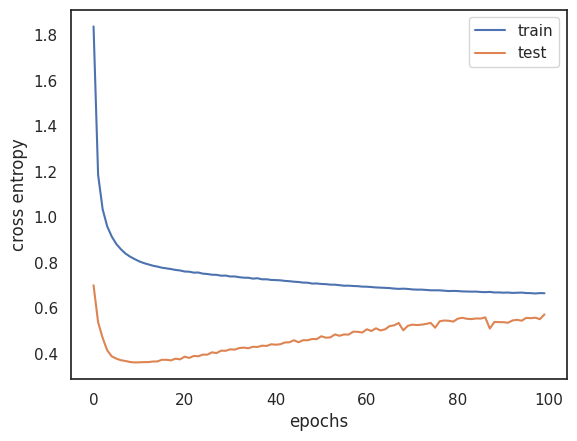

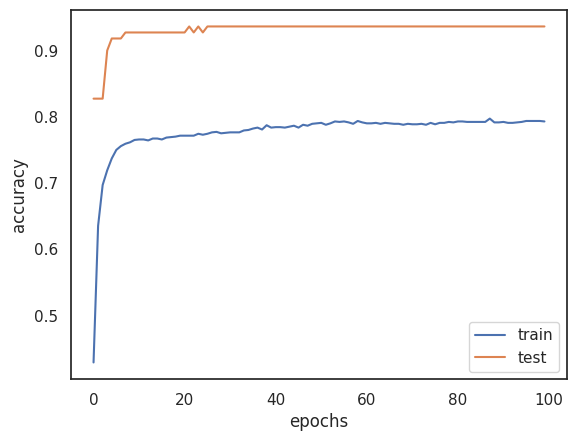

In [20]:

# Plot the loss and accuracy
plt.plot(train_loss_hist, label="train")
plt.plot(test_loss_hist, label="test")
plt.xlabel("epochs")
plt.ylabel("cross entropy")
plt.legend()
plt.show()

plt.plot(train_acc_hist, label="train")
plt.plot(test_acc_hist, label="test")
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.legend()
plt.show()

## Confusion Matrix

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def plot_confusion_matrix(model, X_test, y_test, label_encoder):
    sns.set_theme(style='white')

    # Make sure the model is in evaluation mode
    model.eval()

    # Compute the model predictions
    with torch.no_grad():
        y_pred = model(X_test)
        y_pred = torch.argmax(y_pred, 1)

    # Convert tensors to NumPy arrays for use with sklearn
    y_pred = y_pred.cpu().numpy()
    y_test = y_test.cpu().numpy()

    cm = confusion_matrix(y_test, y_pred, normalize='true')
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                  display_labels=label_encoder.classes_)
    disp.plot(cmap='Blues', values_format='.2f', xticks_rotation='vertical')

    # Increase the size of the plot
    fig = plt.gcf()
    fig.set_size_inches(10, 10)

    # Add title and axis names
    plt.title('Classification Results, n=' + str(len(X_test)), fontsize=14, fontweight='bold')
    plt.xlabel('Predicted', fontsize=14, fontweight='bold')
    plt.ylabel('Actual', fontsize=14, fontweight='bold')

    plt.show()

plot_confusion_matrix(model, X_test, y_test, label_encoder)


ValueError: Classification metrics can't handle a mix of multilabel-indicator and multiclass targets

## Watermark

In [ ]:
# Add watermark with all packages used
get_ipython().run_line_magic('load_ext', 'watermark')

In [ ]:
get_ipython().run_line_magic('watermark', '-v -m -p numpy,pandas,sklearn,matplotlib,seaborn,lightgbm -a Francisco_Marchi@Lamba_Lab_UF')

Author: Francisco_Marchi@Lamba_Lab_UF

Python implementation: CPython
Python version       : 3.8.16
IPython version      : 8.12.2

numpy     : 1.24.3
pandas    : 2.0.2
sklearn   : 1.2.2
matplotlib: 3.7.1
seaborn   : 0.12.2
lightgbm  : 3.3.5

Compiler    : GCC 11.3.0
OS          : Linux
Release     : 5.15.90.1-microsoft-standard-WSL2
Machine     : x86_64
Processor   : x86_64
CPU cores   : 20
Architecture: 64bit

